# Audio Capture & Augmentation
#### Author: Jeromey Schwartz
#### *Audio capture code (indicated with *) supplied by Dr. Jeremy Holleman UNC-Charlotte 

### Purpose:
This will record an audio sample 1 second long at a sampling rate of 16kHz, the samples can then be augmented by adding noise, pitch shifting, or time shifting 

### Program Flow:
1. Load libraries/setup code 
2. Save a number of audio samples 
3. Save ambient noise samples 
4. Noise shift 
5. Time shift 
6. Pitch shift 
7. Save samples names in validation document 

#### Import libraries

In [1]:
import tensorflow as tf
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
import numpy as np
import time
from scipy.io import wavfile
import random
import sys
import io
import os
import pathlib
import glob
from datetime import datetime as dt
from numpy import log as ln
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import IPython
import IPython.display as ipd
import tensorflow as tf
%matplotlib inline
import pyaudio
from queue import Queue
from threading import Thread
import math
import time
import librosa

2023-05-04 23:55:31.765439: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-04 23:55:31.807166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 23:55:32.348257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Set Parameters*

In [2]:
i16min            = -32768
i16max            = 32767
fsamp             = 16000
wave_length_ms    = 1000
wave_length_samps = 16000
window_size_ms    = 60
window_step_ms    = 40
num_filters       = 32
use_microfrontend = True
keyword        = 'computer'#####Insert your keyword
spectrogram_shape = (64, 24, 32, 1)

chunk_duration = 0.25 # Each read length in seconds from mic.
fs = 16000 # sampling rate for mic
sample_rate = 16000 # sampling rate for mic
chunk_samples = int(fs * chunk_duration) # Each read length in number of samples.

# Each model input data duration in seconds, need to be an integer numbers of chunk_duration
feed_duration = 1.0
feed_samples = int(fs * feed_duration)

assert feed_duration/chunk_duration == int(feed_duration/chunk_duration)

#### Create keyword & noise folders*

In [3]:
import os

# Define the path to the parent directory
parent_dir = os.getcwd()
parent_dir = os.path.join(parent_dir, "custom-speech")

# Get the name of the current keyword
keyword = "computer"

# Create the folder name and path
folder = keyword
dir = os.path.join(parent_dir, folder)

# Create the directories if they do not exist
if not os.path.exists(dir):
    os.mkdir(dir)

folder = keyword
dir = os.path.join(parent_dir, folder)
noise_dir = os.path.join(parent_dir, "noise")

if not os.path.exists(dir):
    os.mkdir(dir)

if not os.path.exists(noise_dir):
    os.mkdir(noise_dir)

keyword_directory = dir + '/'
print(keyword_directory)

# Check if the directories were created
if os.path.exists(os.path.join(parent_dir, "computer")):
    print("Directory 'computer' created")
if os.path.exists(os.path.join(parent_dir, "noise")):
    print("Directory 'noise' created")


/home/david/Documents/GitHub/project-2-team-1/training/custom-speech/computer/
Directory 'computer' created
Directory 'noise' created


# Get Custom Data

#### Run this code to get in an audio sample*

In [4]:
import pyaudio

# Create a PyAudio object
pa = pyaudio.PyAudio()

# Get the default input and output devices
default_input_device = pa.get_default_input_device_info()
default_output_device = pa.get_default_output_device_info()

# Print information about the default devices
print("Default input device:")
print(default_input_device)

print("\nDefault output device:")
print(default_output_device)

# # Print information about all available devices
# print("\nAvailable devices:")
# for i in range(pa.get_device_count()):
#     device_info = pa.get_device_info_by_index(i)
#     print(device_info)

Default input device:
{'index': 0, 'structVersion': 2, 'name': 'HDA Intel PCH: ALC897 Analog (hw:0,0)', 'hostApi': 0, 'maxInputChannels': 2, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.005804988662131519, 'defaultLowOutputLatency': 0.005804988662131519, 'defaultHighInputLatency': 0.034829931972789115, 'defaultHighOutputLatency': 0.034829931972789115, 'defaultSampleRate': 44100.0}

Default output device:
{'index': 0, 'structVersion': 2, 'name': 'HDA Intel PCH: ALC897 Analog (hw:0,0)', 'hostApi': 0, 'maxInputChannels': 2, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.005804988662131519, 'defaultLowOutputLatency': 0.005804988662131519, 'defaultHighInputLatency': 0.034829931972789115, 'defaultHighOutputLatency': 0.034829931972789115, 'defaultSampleRate': 44100.0}


ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib dlmisc.c:337:(snd_dlobj_cache_get0) Cannot open shared library libasound_module_rate_samplerate.so (/home/david/anaconda3/lib/alsa-lib/libasound_module_rate_samplerate.so: cannot open shared object file: No such file or directory)
ALSA lib pcm_rate.c:1582:(snd_pcm_rate_open) Cannot find rate converter
ALSA lib dlmisc.c:337:(snd_dlobj_cache_get0) Cannot open shared library libasound_module_rate_samplerate.so (/home/david/anaconda3/lib/alsa-lib/libasound_module_

In [5]:
import sys
print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)

Python version
3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
Version info.
sys.version_info(major=3, minor=10, micro=10, releaselevel='final', serial=0)


In [6]:
# # Queue to communiate between the audio callback and main thread
# q = Queue()
# run = True
# silence_threshold = 100
# # Run the demo for a timeout seconds
# timeout = time.time() + 1 
# # Data buffer for the input wavform
# data = np.zeros(feed_samples, dtype='int16')

# def callback(in_data, frame_count, time_info, status):
#     global run, timeout, data, silence_threshold    
#     if time.time() > timeout:
#         run = False        
#     data0 = np.frombuffer(in_data, dtype='int16')
#     data = np.append(data,data0)    
#     if len(data) > feed_samples:
#         data = data[-feed_samples:]
#         # Process data async by sending a queue.
#         q.put(data)
#     return (in_data, pyaudio.paContinue)

# stream = pyaudio.PyAudio().open(
#     format=pyaudio.paInt16,
#     channels=1,
#     rate=fs,
#     input=True,
#     frames_per_buffer=chunk_samples,
#     input_device_index=23,
#     stream_callback=callback)
# stream.start_stream()
# try:
#     while run:        
#         data = q.get()
# except (KeyboardInterrupt, SystemExit):
#     stream.stop_stream()
#     stream.close()
#     timeout = time.time()
#     run = False      
# stream.stop_stream()
# stream.close()

# sample_rate = fs


# #Displaying wave file data
# plt.plot(np.arange(1*fs)/fs, data)
# plt.show()
# ipd.Audio(data, rate=fs)

#### If the Sample looks good run cell below to save it 

In [7]:
# # #saving the wave file to training_data
# date_str = dt.now().strftime("%H%M%S").lower()
# current_name = f"{keyword_directory}{keyword}_{date_str}.wav".replace("\\", "/")
# write(current_name, sample_rate, data)
# print("Audio sample saved")
# print(current_name)

#### Noise
* To get noise data run "get data" loop again to get ambient room
* Save here
* Get ~3 samples total

In [8]:
# # #saving the wave file to training_data
# date_str = dt.now().strftime("%H%M%S").lower()
# current_name = f"{parent_dir}/noise/noise_{date_str}.wav"
# write(current_name, sample_rate, data)
# print("Audio sample saved as noise")

# Audio Augmentation- Noise
    * This will create copies of sample audio and add pre-recorded noise. 
    * The amplitude of the noise depends on *noise_count*
    * Audio samples and visualizations are created to show noise augmentation

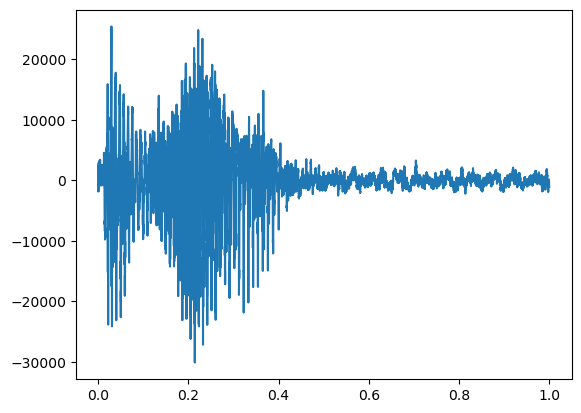

In [9]:
#Selecting augmentation folder & files
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')

#Testing if audio data imported correctly
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [10]:
#Loading noise samples
noise_dir = parent_dir+'/noise'
noise_samples = tf.io.gfile.glob(str(noise_dir) + '/*.wav')
print("Noise Samples:", len(noise_samples))

Noise Samples: 3


#### Set Augment count

In [11]:
#noise_count will deteremine how many augmentations will be created
    #noise_count=1 will be a copy with noise augmentation * 0
    #noise_count=2 will be noise_count=1 plus a copy with noise augmentation * 1
    #noise_count=2 will be noise_count=2 plus a copy with noise augmentation * 2  
    #and so on 

noise_count=6
print("This will expand the current", len(filenames), "files by creating an addtional",len(filenames)*len(noise_samples)*noise_count, "noise augmented files, to give a total of",len(filenames)*len(noise_samples)*(noise_count)+len(filenames),"files")

This will expand the current 14 files by creating an addtional 252 noise augmented files, to give a total of 266 files


#### Creating Noise Augmentation

In [12]:
#dict holds samples for plotting
noise_dict={}
for index in range(len(filenames)):
    test_wav=filenames[index]
    fs, test_wav = wavfile.read(test_wav)
    if (len(test_wav) < fs):
        padding=fs-len(test_wav)
        extra_padding=np.zeros(padding).astype(np.int16) #array of empty audio to pad with
        test_wav=np.concatenate((test_wav,extra_padding),axis=0).astype(np.int16)
    noise_dict[0]=test_wav.astype(np.int16)
    for i in range(len(noise_samples)):
        noise=noise_samples[i]
        fs, noise = wavfile.read(noise)
        for j in range(noise_count):
            noise_multiplier=round(max(test_wav)*(j/2000))
            noise_lvl=noise*noise_multiplier
            test_wave_with_noise=np.add(test_wav,noise_lvl)
            current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_Noise{i}_Multiplier{j}.wav"
            write(current_name, fs, test_wave_with_noise)
            noise_dict[j+1]=test_wave_with_noise.astype(np.int16)
            noise_dict[j+5]=noise_lvl.astype(np.int16)

#### Plotting noise augmenation

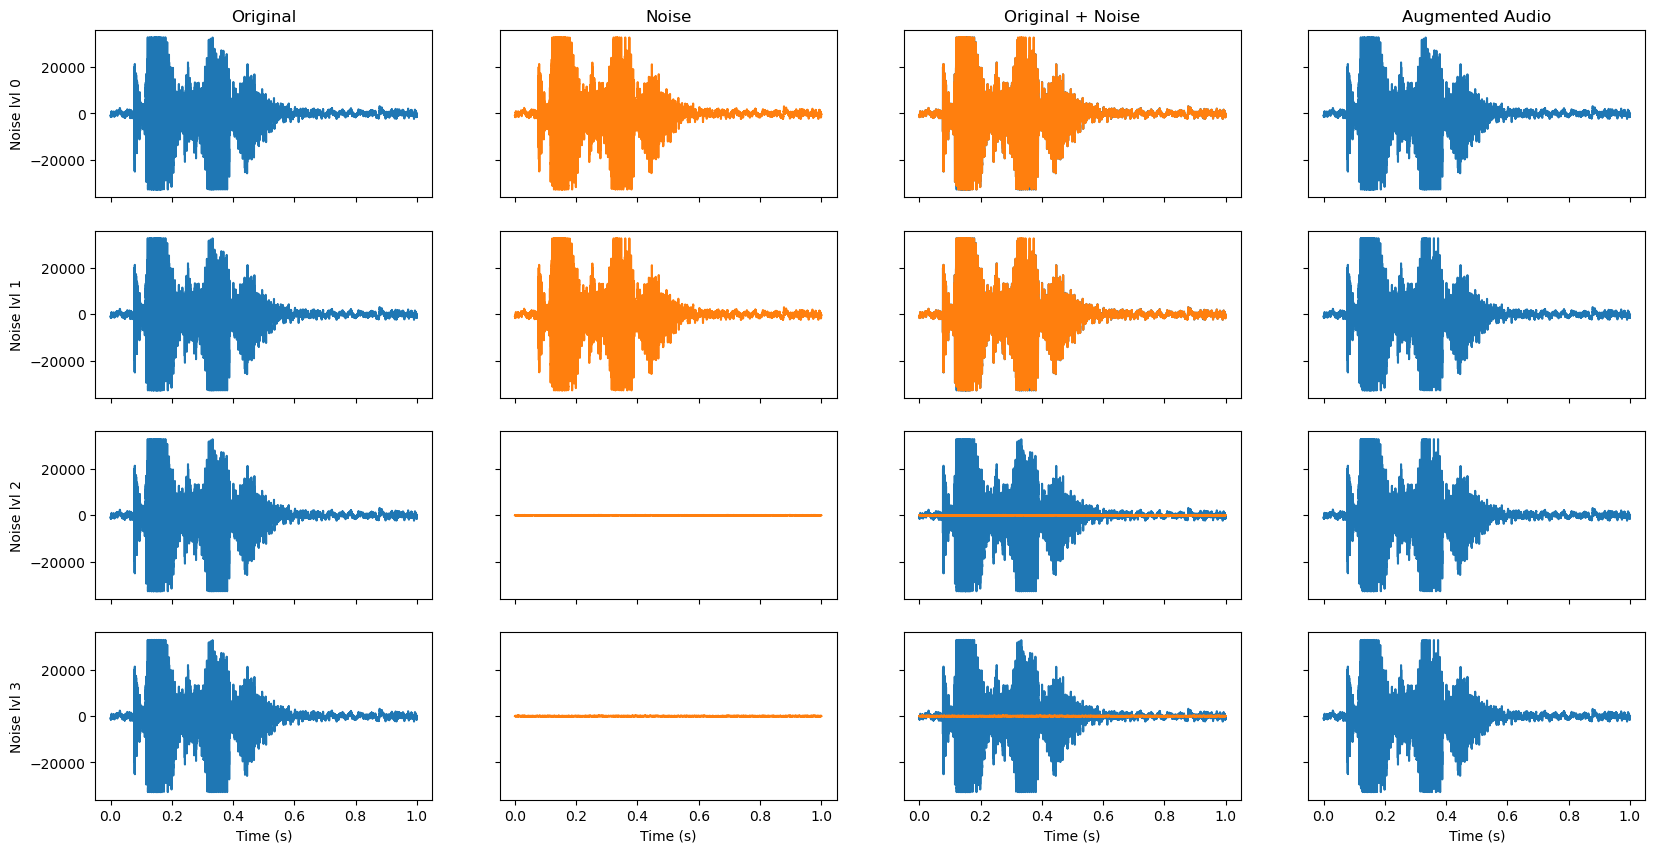

In [13]:
#Only plots up to noise lvl 3
fig, axs = plt.subplots(4, 4,figsize=(20,10), sharex=True,sharey=True)
axs[0,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[0,1].plot(np.arange(1*fs)/fs, noise_dict[5], 'tab:orange')
axs[0,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[0,2].plot(np.arange(1*fs)/fs, noise_dict[5])
axs[0,3].plot(np.arange(1*fs)/fs, noise_dict[1])

axs[0, 0].set_title("Original")
axs[0, 1].set_title("Noise")
axs[0, 2].set_title("Original + Noise")
axs[0, 3].set_title("Augmented Audio")

axs[0, 0].set(xlabel='Time (s)', ylabel='Noise lvl 0')
axs[1, 0].set(xlabel='Time (s)', ylabel='Noise lvl 1')
axs[2, 0].set(xlabel='Time (s)', ylabel='Noise lvl 2')
axs[3, 0].set(xlabel='Time (s)', ylabel='Noise lvl 3')

axs[1,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[1,1].plot(np.arange(1*fs)/fs, noise_dict[6], 'tab:orange')
axs[1,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[1,2].plot(np.arange(1*fs)/fs, noise_dict[6])
axs[1,3].plot(np.arange(1*fs)/fs, noise_dict[2])

axs[2,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[2,1].plot(np.arange(1*fs)/fs, noise_dict[7], 'tab:orange')
axs[2,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[2,2].plot(np.arange(1*fs)/fs, noise_dict[7])
axs[2,3].plot(np.arange(1*fs)/fs, noise_dict[3])

axs[3,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[3,1].plot(np.arange(1*fs)/fs, noise_dict[8], 'tab:orange')
axs[3,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[3,2].plot(np.arange(1*fs)/fs, noise_dict[8])
axs[3,3].plot(np.arange(1*fs)/fs, noise_dict[4])

for ax in axs.flat:
    ax.set(xlabel='Time (s)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#### Listen to noise augmenation

In [14]:
#Only samples up to noise lvl 3
from IPython.display import Audio 
from IPython.display import display

print("Noise lvl 0:")
display(Audio(noise_dict[0], rate=fs))
print("Noise lvl 1:")
display(Audio(noise_dict[2], rate=fs))
print("Noise lvl 2:")
display(Audio(noise_dict[3], rate=fs))
print("Noise lvl 3:")
display(Audio(noise_dict[4], rate=fs))

Noise lvl 0:


Noise lvl 1:


Noise lvl 2:


Noise lvl 3:


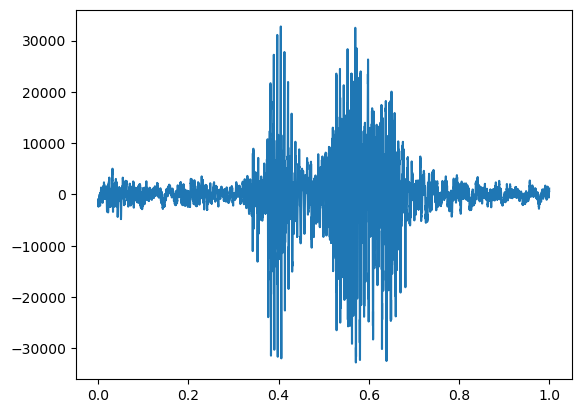

The current number of files in directory is 266


In [15]:
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Testing if audio data imported correctly
filenames[0]
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

print("The current number of files in directory is", len(filenames))

In [16]:
#Need to update filenames


#### Set Augment count

#How many of the files do you want to have total?
desired_number_of_files=4000

#How do you want to pitch shift
    #positive=high pitch, negative = low pitch
    #0.25 is a good value
pitch_shift=0.25

outer_range= math.ceil((np.log(desired_number_of_files / len(filenames)) / np.log(2) ))
outer_range

4

In [17]:
import tqdm
import tensorflow as tf

if tf.test.is_gpu_available():
    print('GPU available')
    devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(devices[0], True)
    device_name = '/GPU:0'
else:
    print('No GPU available, using CPU instead')
    device_name = '/CPU:0'

pitch_dict={}

with tf.device(device_name):
    for i in range(outer_range):
        
        for index in tqdm.tqdm(range(len(filenames)), desc=f"Processing pitch shift {i}"):
            test_wav=filenames[index]
            fs, test_wav = wavfile.read(test_wav)
            if i==0:
                pitch_dict[i]=test_wav
            test_wav_float=test_wav.astype(float)
            test_wav_pitch_shifted = librosa.effects.pitch_shift(test_wav_float, sr=sample_rate, n_steps=pitch_shift*(i+1))
            test_wav_pitch_shifted_int=test_wav_pitch_shifted.astype(np.int16)
            current_name = str(keyword_directory)+str(keyword) +f"_Pitch_Shift_{i}_{index}.wav"    
            write(current_name, fsamp, test_wav_pitch_shifted_int)

            files_in_folder=len(tf.io.gfile.glob(str(data_dir) + '/*.wav'))
            pitch_dict[i+1]=test_wav_pitch_shifted_int
            if (files_in_folder >= desired_number_of_files):
                break 
        filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
        #update filenames with newly created files    
        if (files_in_folder >= desired_number_of_files):
            break 
print("Congratulations, the current number of files in directory is", len(filenames))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-05-04 23:55:36.043256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-04 23:55:36.072562: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-04 23:55:36.168331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

No GPU available, using CPU instead


Processing pitch shift 3:  88%|███████████▍ | 1871/2128 [00:37<00:05, 49.60it/s]

Congratulations, the current number of files in directory is 4000


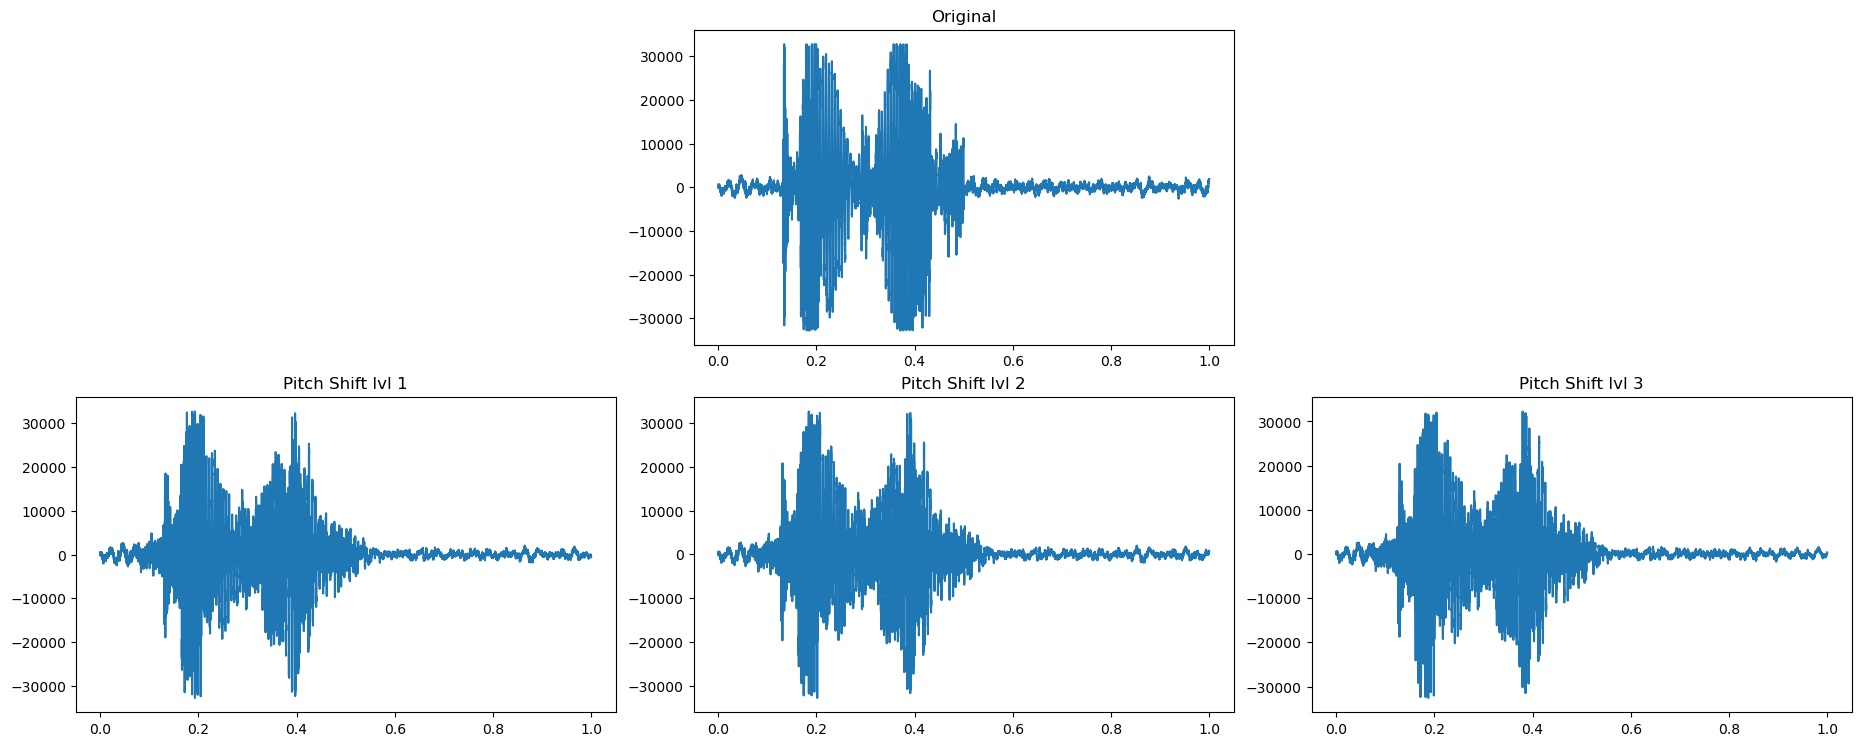

In [18]:
fig = plt.figure(constrained_layout=True)
axs = fig.add_gridspec(3, 3)

f_ax0 = fig.add_subplot(axs[0, 1])
f_ax1 = fig.add_subplot(axs[1, 0])
f_ax2 = fig.add_subplot(axs[1, 1])
f_ax3 = fig.add_subplot(axs[1, 2])

f_ax0.plot(np.arange(1*fs)/fs, pitch_dict[0])
f_ax0.set_title('Original')

if outer_range>1:
    f_ax1.plot(np.arange(1*fs)/fs, pitch_dict[1])
    f_ax1.set_title('Pitch Shift lvl 1')
if outer_range>2:
    f_ax2.plot(np.arange(1*fs)/fs, pitch_dict[2])
    f_ax2.set_title('Pitch Shift lvl 2')
if outer_range>3:
    f_ax3.plot(np.arange(1*fs)/fs, pitch_dict[3])
    f_ax3.set_title('Pitch Shift lvl 3')

fig.set_size_inches(18.5, 10.5, forward=True)
pass

In [19]:
#### Listen to Pitch Shift

from IPython.display import Audio 
from IPython.display import display

print("Original:")
display(Audio(pitch_dict[0], rate=fs))

if outer_range>1:
    print("Pitch Shift lvl 1")
    display(Audio(pitch_dict[1], rate=fs))
if outer_range>2:
    print("Pitch Shift lvl 2")
    display(Audio(pitch_dict[2], rate=fs))
if outer_range>3:
    print("Pitch Shift lvl 3")
    display(Audio(pitch_dict[3], rate=fs))

Original:


Pitch Shift lvl 1


Pitch Shift lvl 2


Pitch Shift lvl 3


# Write augmented data files to testing and validation .txt file 

In [42]:
from pathlib import Path
import random

# Set the directory path containing the WAV files
data_dir = './custom-speech'

# Set the paths and file names for the validation and testing files
val_file_name = './custom-speech/validation_list.txt'
test_file_name = './custom-speech/testing_list.txt'

# Set the split percentage for the validation and testing sets
val_pct = 0.2
test_pct = 0.6

# Create a list of keywords (folder names)
keywords = ['computer']

# Iterate over all the keywords
for keyword in keywords:
    # Get a list of all WAV files in the keyword directory
    keyword_files = tf.io.gfile.glob(str(os.path.join(data_dir, keyword)) + '/*.wav')
    
    # Shuffle the files randomly
    random.shuffle(keyword_files)
    
    # Calculate the number of files for each split
    num_files = len(keyword_files)
    num_val = int(val_pct*num_files)
    num_test = int(test_pct*num_files)
    num_train = num_files - num_val - num_test
    
    # Append the validation list file
    with open(val_file_name, 'a') as f:
        for file in keyword_files[:num_val]:
            f.write(keyword + '/' + os.path.basename(file) + '\n')
    print(num_val, keyword, "samples added to", val_file_name)
    
    # Append the testing list file
    with open(test_file_name, 'a') as f:
        for file in keyword_files[num_val:num_val+num_test]:
            f.write(keyword + '/' + os.path.basename(file) + '\n')
    print(num_test, keyword, "samples added to", test_file_name)

800 computer samples added to ./custom-speech/validation_list.txt
2400 computer samples added to ./custom-speech/testing_list.txt


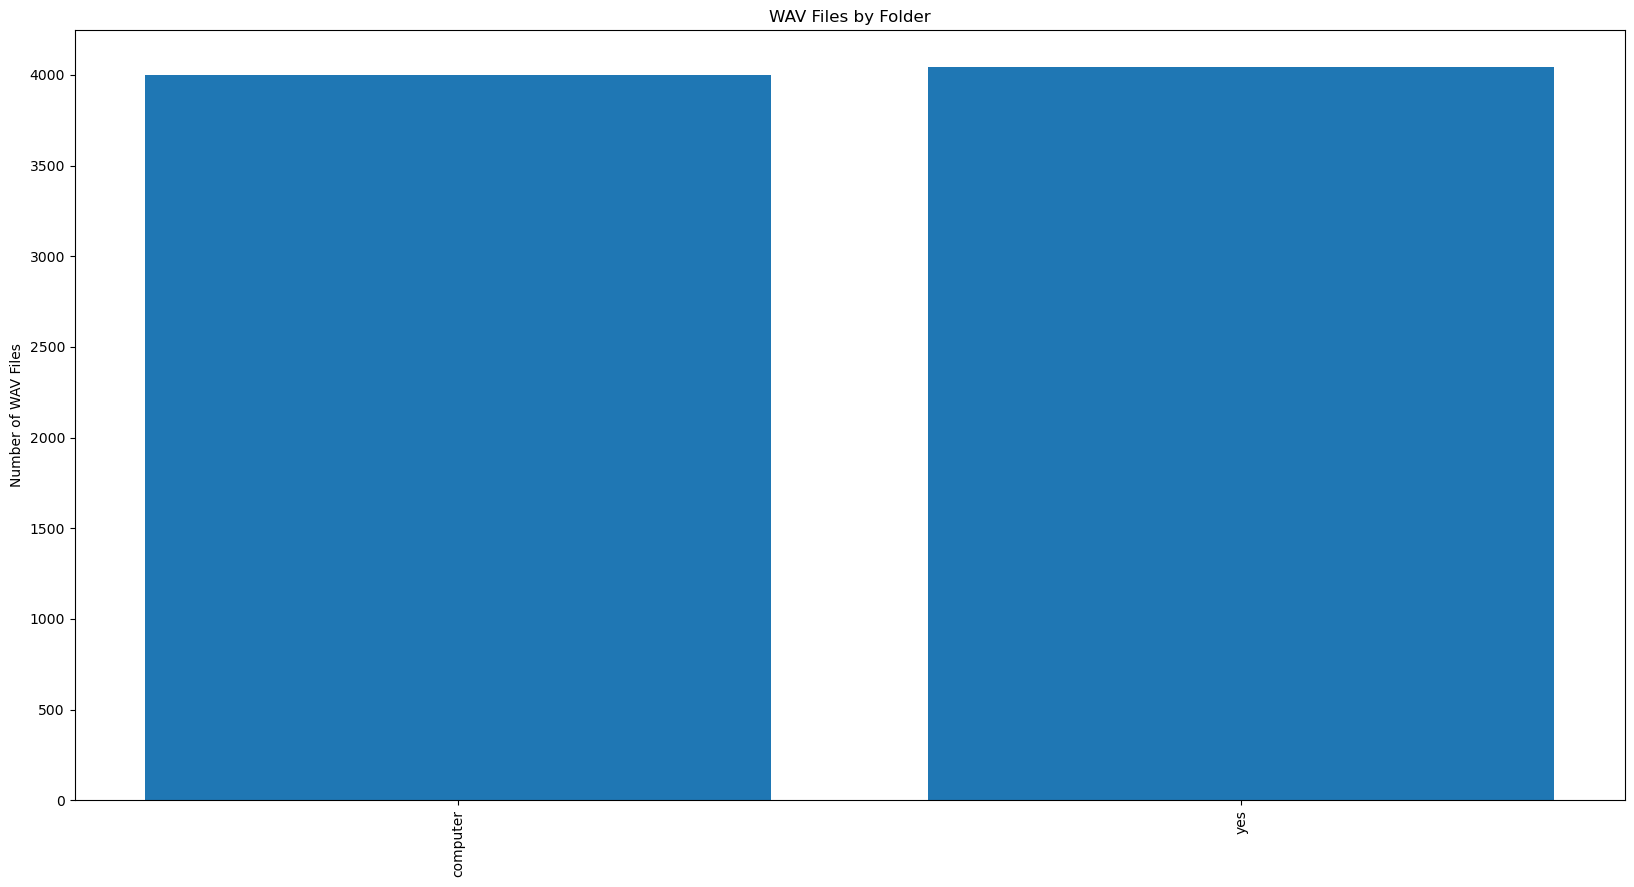

In [37]:
import os
import matplotlib.pyplot as plt

data_dir = './custom-speech/'

folder_counts = {}
for subdir in os.listdir(data_dir):
    subdir_path = os.path.join(data_dir, subdir)
    if os.path.isdir(subdir_path) and subdir != 'speech_commands_v0.02' and subdir != 'noise' and subdir != 'unused_noise_' and subdir != '.ipynb_checkpoints':
        folder_counts[subdir] = len([f for f in os.listdir(subdir_path) if f.endswith('.wav')])

fig = plt.figure(figsize=(20, 10))
sorted_keys = sorted(folder_counts.keys())
plt.bar(range(len(folder_counts)), [folder_counts[key] for key in sorted_keys], align='center')
plt.xticks(range(len(folder_counts)), sorted_keys, rotation=90)
plt.ylabel('Number of WAV Files')
plt.title('WAV Files by Folder')
plt.savefig('./figs/all wav files')
plt.show()

In [43]:
# print the numbers for the "yes" and "computer" folders
print("Number of WAV files in the 'yes' folder:", folder_counts.get("yes", 0))
print("Number of WAV files in the 'computer' folder:", folder_counts.get("computer", 0))

Number of WAV files in the 'yes' folder: 4044
Number of WAV files in the 'computer' folder: 4000
